# Computational Tomography with Un-trained Neural Networks

In this exercise, the task is to reconstruct an image in the context of computational tomography. The original images is given as $x$ below, and is loaded from the the file origina.npy, which must be in the same folder as this notebook.

Below, you are given the measurement operator $A$ and a measurement obtained as
$$
y = A x.
$$
The task is to reconstruct the image $x$ from $y$ with an un-trained neural network. You are welcome to use code from any repository of your choice, for example:
- Deep image prior: [https://github.com/DmitryUlyanov/deep-image-prior](https://github.com/DmitryUlyanov/deep-image-prior)
- Deep decoder: [https://github.com/reinhardh/supplement_deep_decoder](https://github.com/reinhardh/supplement_deep_decoder)
- Compressive sensing with the deep decoder [https://github.com/MLI-lab/cs_deep_decoder](https://github.com/MLI-lab/cs_deep_decoder)

To make this work, you might have to tune the network and optimization appropriately.


In [1]:
from google.colab import drive
import os

gdrive_path = '/content/gdrive/MyDrive/Colab Notebooks/dlip/HW9/'

# This will mount your google drive under 'MyDrive'
drive.mount('/content/gdrive', force_remount=True)
# In order to access the files in this notebook we have to navigate to the correct folder
os.chdir(gdrive_path)
# Check manually if all files are present
print(sorted(os.listdir()))

Mounted at /content/gdrive
['__MACOSX', 'original.npy', 'untrained_network_problem.ipynb']


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision.transforms.functional as F
from tqdm import tqdm

In [3]:
#Load ground truth

x_path = gdrive_path + '/original.npy'  #path to ground truth
x = np.load(x_path)        #load ground truth

x = torch.FloatTensor(x)

torch.Size([512, 512])


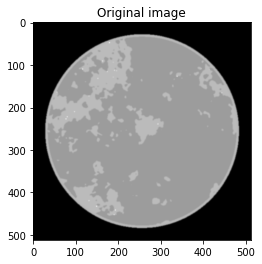

In [4]:
#Plot original image
print(x.size())
plt.imshow(x)
plt.gray()
plt.title('Original image')
plt.show()

In the following we define the forward model $A$, which represents a parallel beam projection (also known as a discrete Radon transform) with a 4x acceleration factor.

In [5]:
#Forward Model A

def A(image):
    n = image.shape[0]
    m = n // 4  # 4 times acceleration
    pbp = torch.zeros(m, n)
    image = image.unsqueeze(0)
    
    for i in range(m):
        proj = F.rotate(image, -i*180/m).squeeze(0)
        pbp[i,:] = torch.sum(proj,0)
        
    return pbp

The measurement, $y$, is created by: $y=A(x)$

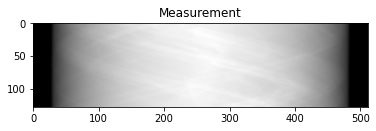

In [6]:
#create and plot measurement
y = A(x)

plt.imshow(y)
plt.title('Measurement')
plt.show()

Define your codes below.

In [43]:
class Decoder(nn.Module):
    def __init__(self, image_shape=(512, 512)):
        super(Decoder, self).__init__()
        
        self.image_shape = image_shape
        self.num_chans = [64, 64, 64, 64, 64]
        self.convblocks = nn.ModuleList()
        for i in range(len(self.num_chans) - 1):
            self.convblocks.append(self.upsampling_block(self.num_chans[i], self.num_chans[i + 1]))
        
        self.fc = nn.Sequential(
            nn.Conv2d(self.num_chans[-1], out_channels=1, kernel_size=1, stride=1, padding=0),
            nn.Sigmoid()
        )
    
    def upsampling_block(self, in_chans, out_chans):
        convblock = nn.Sequential(
            # nn.Conv2d(num_channels_up[i], num_channels_up[i+1],  filter_size_up[i], 1, pad=pad)
            nn.Conv2d(in_chans, out_chans, kernel_size=1, stride=1, padding=0),
            nn.Upsample(scale_factor=2, mode='bilinear'),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_chans),
        )
        return convblock

    def forward(self, x):
        x = x.view(1, self.num_chans[0], 32, 32)
        for conv in self.convblocks:
            x = conv(x)
        x = self.fc(x)
        # print(x.shape)
        x = x.view(512, 512)
        return x

In [44]:
def reconstructing(net, measurement, latent_param, device, learning_rate=1e-6, num_steps=10000):
    losses = []
    images = []
    optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[1000, 3000, 4000], gamma=0.4)
    criterion = nn.MSELoss()

    with tqdm(range(num_steps)) as tepoch:
        for i in tepoch:
            optimizer.zero_grad()
            output = net(latent_param)
            loss = criterion(A(output).to(device), measurement)
            loss.backward()
            optimizer.step()
            scheduler.step()

            losses.append(loss.item())
            tepoch.set_postfix(loss=loss.item(), lr=scheduler.get_last_lr()[0])

            if (i + 1) % 5000 == 0:
                images.append(output)

    return losses, images

The device is cuda


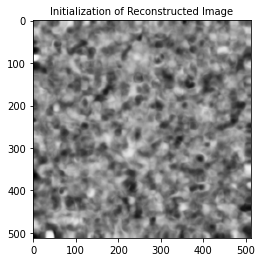

In [47]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('The device is', device)

# Initialize the model and input parameters
mmt_h, mmt_w = y.size()
latent_param = torch.rand(mmt_h, mmt_w)
decoder = Decoder()

# Visualize the initialization
init = decoder(latent_param)
plt.imshow(init.detach().numpy())
plt.title('Initialization of Reconstructed Image', fontsize=10)
plt.show()

In [52]:
# To device
decoder.to(device)
y, latent_param = y.to(device), latent_param.to(device)

# Training
rec_losses, rec_images = reconstructing(decoder, y, latent_param, device, learning_rate=0.001, num_steps=1000)
rec_image = decoder(latent_param)

100%|██████████| 1000/1000 [01:23<00:00, 12.03it/s, loss=0.11, lr=0.0004]


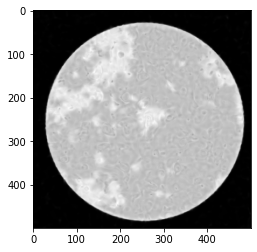

In [53]:
img = rec_image.cpu().detach().numpy()
plt.imshow(img[:500, :500])
plt.show()